# Intro
This is a jupyter notebook containing  code relevant to finding distant pairs using BiG-SLICE features  

This code is part of the BiG-SCAPE 2.0 thesis project  

Start by importing these modules

In [1]:
import multiprocessing
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plots.hist

import data
import truth.truth as truth
import input.paths as paths
import input.bigslice_hmm

import predictions
import predictions.tests

import validation

from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

import math

The following code instantiates any relevant paths to data or output. Make sure to change these for your purposes.
Not all the paths may be relevant, e.g. if you are using the bigscape_distances.tsv that is included in this repository.

In [2]:

# location of the core and bio pfam information tab separated files.
# these are included in this repository, but if you want to get them from BiG-SLICE directly point them to their respective locations
CORE_PFAM_TSV = "corepfam.tsv"
BIO_PFAM_TSV = "biopfam.tsv"
# location of the full bigscape distances tab separated file.
# this file is created if you are loading new values from a run using the path after this one
FULL_TSV = "bigscape_distances.tsv"
# Base folder of Cluster files generated by BiG-SCAPE for a run. e.g:
BIGSCAPE_CLUSTER_FILES = "D:/Temp/2022-03-22_09-18-06_hybrids_global"

# location of the sqlite database to analyze
SQLITE_DB = "D:/Temp/benchmark-out/sqlite-10/data.db"


The following code loads data from a BiG-SCAPE run. Point the RUN_PATH to a BiG-SCAPE result folder and it will collect all BGC pair distances
It will then save these distances to the bigscape_distances.tsv file indicated by the FULL_TSV path above

If you want to recreate the bigscape_distances.tsv, run BiG-SCAPE 2.0 on the closed streptomyces dataset provided here:
https://zenodo.org/record/1532752/files/Closed_Streptomyces_antiSMASH_results.zip?download=1
and run using bigscape.py --i /path/to/streptomyces -o ~/bigscape-streptomyces-output --cutoff 1.0
then uncomment and run the following code block

In [3]:
# TRUTH_DISTANCES = truth.get_distances_from_results(BIGSCAPE_CLUSTER_FILES, "1.00")
# truth.write_full_file(FULL_TSV, TRUTH_DISTANCES)

Otherwise, just run the below code block to load the ground truth for validation

In [3]:
print("Loading truth")
# load truth values
TRUTH_DISTANCES = truth.from_file(FULL_TSV)

TRUTH_PAIRS = validation.pairs_from_distances(TRUTH_DISTANCES)

print("Loading stored info from database")
DB = data.Database(SQLITE_DB)

BGC_IDS = data.get_bgc_ids(DB)
HMM_IDS = data.get_hmm_ids(DB)

BGC_ID_NAME_DICT = data.get_bgc_id_name_dict(DB)
BGC_NAME_ID_DICT = {name: id for id, name in BGC_ID_NAME_DICT.items()}

CORE_PFAM_ACC, CORE_PFAM_NAMES = input.bigslice_hmm.get_core_pfam(CORE_PFAM_TSV)
BIO_PFAM_ACC, BIO_PFAM_NAMES = input.bigslice_hmm.get_bio_pfam(BIO_PFAM_TSV)
# get corresponding ids
CORE_PFAM_IDS = data.get_core_pfam_ids(DB, CORE_PFAM_ACC, CORE_PFAM_NAMES)
BIO_PFAM_IDS = data.get_bio_pfam_ids(DB, BIO_PFAM_ACC, BIO_PFAM_NAMES)
CORE_PFAM_SET = set(CORE_PFAM_IDS)
BIO_PFAM_SET = set(BIO_PFAM_IDS)
print("Done")
print(len(BGC_IDS), "BGCs in database")


Loading truth
Loading stored info from database
Done
271 BGCs in database


First bit of data exploration: show a histogram of values in the truth data.
This gives a general idea of how the true distances are distributed

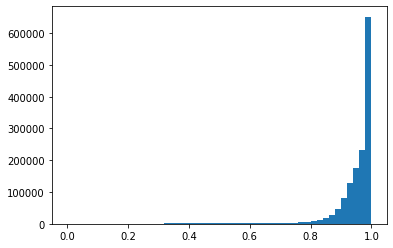

In [4]:
# show hist of true distances
plots.hist.from_distances(TRUTH_DISTANCES, max=len(TRUTH_DISTANCES), bins=50)

What this shows is that the vast majority of distances in the ground truth are way beyond the default BiG-SCAPE cutoff of 0.3
In turn this means that the vast majority of BGCs are unrelated, and if we can filter these out before we run BiG-SCAPE's pairwise distance calculation we can gain a lot of time

We are trying to use the fast calculation of BiG-SLICE features to thin out the crowd of BGC comparisons.
We will load the data into a format that can be used by skilearn, which we're using for most analyses

In [5]:

print("Instantiating dataframes")
# instantiate dataframes
FEATURES = pd.DataFrame(
    np.zeros((len(BGC_IDS), len(HMM_IDS)), dtype=np.uint8),
    index=BGC_IDS,
    columns=HMM_IDS
)

# fetch feature values from db
BGC_HMM_FEATURES = data.get_features(DB)
for bgc_id, hmm_id, value in BGC_HMM_FEATURES:
    FEATURES.at[bgc_id, hmm_id] = value
print("Done")

Instantiating dataframes
Done


We want to know more about what this data looks like. It probably helps to get data labels based on truth for visualisation if we want to do it.
We get a label set based on the distances. This probably isn't super accurate but it will give us a general idea of which data points belong together.
The labels are assembled by going through all distances and assigning pairs with distance < 0.3 to a label
If later on there is a pair where BGC A already has a label, it will set or overwrite BGC B's label with that of BGC A.
The same goes for if there is already a label set on BGC B. It will then set the label of BGC A to that of BGC B.

IF the total number of pairs / 2 is larger than the total number of BGCs, this will overwrite labels. Thus this is probably not super accurate. This data is also missing the initial separation of bgcs due to product type classification

In [5]:
# get a dataframe of labels associated with each BGC based on truth
# this means a dataframe of bgcs where bgcs with a distance of < 0.3 belong to
# the same 'cluster'
TRUTH_LABELS = validation.labels_from_distances(TRUTH_DISTANCES, BGC_NAME_ID_DICT, BGC_IDS)

LABEL_LIST = [TRUTH_LABELS.at[bgc_id,"label"] for bgc_id in BGC_IDS]
print("Found", max(TRUTH_LABELS["label"]), " labels")
# check how this measures up to the pairs in the truth data
classified = len(list(filter(lambda item: item > 0, LABEL_LIST)))
unclassified = len(LABEL_LIST) - classified
print(classified, "BGCs are labeled")
print(unclassified, "BGCs are unlabeled")
PAIRED_BGCS = set()
for pair in TRUTH_PAIRS[0]:
    PAIRED_BGCS.add(pair[0])
    PAIRED_BGCS.add(pair[1])
print(len(PAIRED_BGCS), "BGCs are actually paired")

Found 601  labels
1669 BGCs are labeled
1313 BGCs are unlabeled
1669 BGCs are actually paired


We might want to consider the features generated from core domains and biosynthetic domains seperately. There are a few ways to do this but the easiest is to make some sort of sum of the features in these two classes and create a two-dimensional data frame.

In [8]:
# this dataframe contains sums of features from biosynthetic pfams and core pfams separately
SUMS_CORE = pd.DataFrame(FEATURES[CORE_PFAM_IDS].sum(axis=1), columns=["sum_core"])
SUMS_BIO = pd.DataFrame(FEATURES[BIO_PFAM_IDS].sum(axis=1), columns=["sum_bio"])
FEATURES_SUMS = pd.merge(SUMS_CORE, SUMS_BIO, left_index=True, right_index=True)

We can look at what this data looks like using the labels from earlier

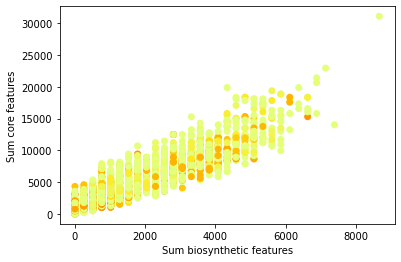

In [9]:
# show a plot of how this data looks lke
plt.xlabel("Sum biosynthetic features")
plt.ylabel("Sum core features")
plt.scatter(FEATURES_SUMS["sum_core"], FEATURES_SUMS["sum_bio"], c=LABEL_LIST, cmap="Wistia")
plt.show()

This doesn't show any clear separation of pairs using this. Then again, it's hard to tell since there are quite a lot of labels.

It's unlikely that simple summation of data is a good method of reducing dimensionality.
If we need to we can return to reducing dimensionality later

For now we will look at some things we can do in a higher dimensional space. Starting simple with euclidean distance calculation. The following calculates euclidean distances on all rows and features and plots the distances calculated in a histogram.

This is using all entries, so it may take some time.

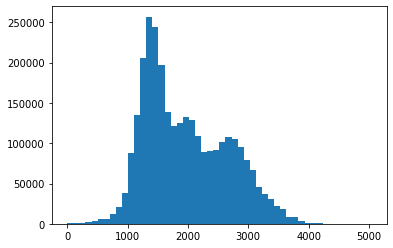

In [10]:
EUCLIDEAN_DISTS = predictions.get_distances(FEATURES, BGC_ID_NAME_DICT, metric="euclidean")
plots.hist.from_distances(EUCLIDEAN_DISTS, max=None, bins=50)

This graph does not correspnd well at all to the graph we got earlier, so there's no reason to think euclidean distances will perform well as a cutoff
Still, we can try. We can explore some cutoff tresholds and see what happens
In this case we will try invervals of 200 starting at 1000, and ending at 3000

In [11]:
predictions.tests.distance.run_upper(
    EUCLIDEAN_DISTS,
    TRUTH_PAIRS,
    upper_range=10,
    upper_cutoff_step=200,
    upper_cutoff_start=1000
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
1000,0,2338752,45898,NA,0.0,1.0,0.999,NA,0.999,0,0,2338752,2620
1200,0,2236930,147720,NA,0.0,1.0,0.999,NA,0.999,0,0,2236930,2481
1400,0,2000448,384202,NA,0.0,1.0,0.999,NA,0.999,0,0,2000448,2163
1600,0,1695393,689257,NA,0.0,1.0,0.999,NA,0.999,0,0,1695393,1811
1800,0,1443159,941491,NA,0.0,1.0,0.999,NA,0.999,0,0,1443159,1554
2000,0,1197316,1187334,NA,0.0,1.0,0.999,NA,0.999,0,0,1197316,1297
2200,0,960214,1424436,NA,0.0,1.0,0.999,NA,0.999,0,0,960214,1028
2400,0,793047,1591603,NA,0.0,1.0,0.999,NA,0.999,0,0,793047,877
2600,0,624307,1760343,NA,0.0,1.0,0.999,NA,0.999,0,0,624307,689
2800,0,428750,1955900,NA,0.0,1.0,0.999,NA,0.999,0,0,428750,480


From the looks of it the ratio of true negative to false negative remains the same, so it seems we are arbitrarily eliminating pairs doing this.  
we will have to find a better way of eliminating pairs than calculating a simple euclidean distance

We can try a different metric, like cosine similarity

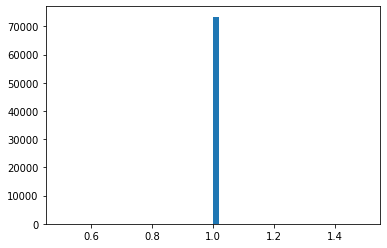

In [8]:
COSINE_DISTS = predictions.get_cosine_distance(FEATURES, BGC_ID_NAME_DICT)
# plot
plots.hist.from_distances(COSINE_DISTS, max=None, bins=50)

This looks a lot more similar to the truth distances calculated earlier. let's see how they measure up

In [13]:
predictions.tests.distance.run_upper(
    COSINE_DISTS,
    TRUTH_PAIRS,
    upper_range=7,
    upper_cutoff_step=0.1,
    upper_cutoff_start=0.4
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.4,0,4402201,45452,NA,0.0,1.0,0.999,NA,0.999,0,0,4402201,4791
0.5,0,4336027,111626,NA,0.0,1.0,0.999,NA,0.999,0,0,4336027,4726
0.6,0,4237228,210425,NA,0.0,1.0,0.999,NA,0.999,0,0,4237228,4603
0.7,0,4133992,313661,NA,0.0,1.0,0.999,NA,0.999,0,0,4133992,4471
0.8,0,3869045,578608,NA,0.0,1.0,0.999,NA,0.999,0,0,3869045,4168
0.9,0,3247464,1200189,NA,0.0,1.0,0.999,NA,0.999,0,0,3247464,3493
1.0,0,1828067,2619586,NA,0.0,1.0,0.999,NA,0.999,0,0,1828067,2048


Similar to the euclidean distance cutoffs, no great success here.

The results may be skewed by the presence of a large amount of zeros in the matrix.  
We can check this by plotting the length of domains (which should relate to number of features > 0) to the distances  
There should be some sort of correlation

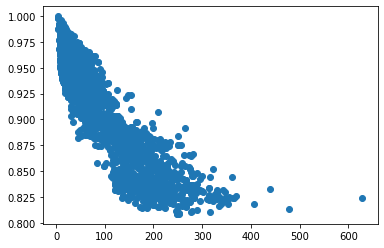

In [6]:
# instantiate a new dataframe, making sure to only fill in 0 when a 0 is actually found in features. this will be important later
# otherwise this dataframe is filled with NaN
FEATURES_NAN = pd.DataFrame(
    np.nan,
    index=BGC_IDS,
    columns=HMM_IDS
)

# fetch feature values from db
for bgc_id, hmm_id, value in BGC_HMM_FEATURES:
    FEATURES_NAN.at[bgc_id, hmm_id] = value


FEATURES_COUNTS = pd.DataFrame(FEATURES_NAN.count(axis=1), columns=["domain_count"])
COSINE_DISTS = 1 - cosine_similarity(FEATURES)
DIST_MEAN = pd.DataFrame(COSINE_DISTS.mean(axis=1), columns=["sum_dist"])
plt.scatter(FEATURES_COUNTS, DIST_MEAN)

So there is. The graph means that the lower the number of domains, the higher the average distance. this is not necessarily correct.  
In order to correct for this we can try ignoring any feature that is missing in either sample (previously these were set to 0)
```
a, b, c, d, e, f, g
x, x, 0, x, 1, 5, x
x, 1, 3, 1, 5, x, x
```
becomes
```
b, c, d, e, f
0, 0, 0, 1, 5
1, 3, 1, 5, 0
```
And cosine distances are calculated from this instead

The following bit is either suboptimal or just expensive.  
In this case we execute this as if we have already divided the BGCs into classes and are doing the same comparisons BiG-SCAPE will do  
For the record, this is how many comparisons there are in BiG-SCAPE, in our sample set

In [15]:
len(TRUTH_DISTANCES)

1440847

The following code is not optimal and will take some time to execute

In [7]:
COSINE_DIST_CORR = predictions.get_corr_cosine_dists(
    TRUTH_DISTANCES,
    BGC_HMM_FEATURES,
    BGC_IDS,
    BGC_NAME_ID_DICT
)

10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done


We can see what the distances look like in a histogram again:

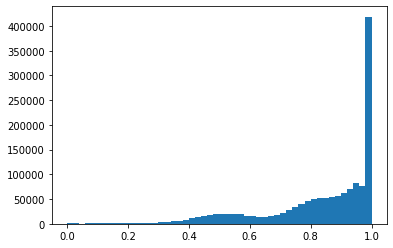

In [38]:
plots.hist.from_distances(COSINE_DIST_CORR, max=None, bins=50)

This doesn't look like the truth distribution but it sure looks interesting.  
We can also take another look at the mean distances vs domain length

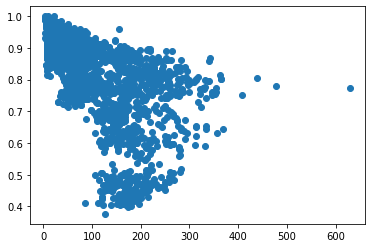

In [33]:
COSINE_DIST_CORR_MATRIX = pd.DataFrame(index=BGC_IDS, columns=BGC_IDS)
for pair in COSINE_DIST_CORR:
    bgc_name_a, bgc_name_b, distance = pair
    bgc_id_a = BGC_NAME_ID_DICT[bgc_name_a]
    bgc_id_b = BGC_NAME_ID_DICT[bgc_name_b]
    COSINE_DIST_CORR_MATRIX.at[bgc_id_a, bgc_id_b] = distance
COSINE_DIST_CORR_MEAN = pd.DataFrame(COSINE_DIST_CORR_MATRIX.mean(axis=1), columns=["sum_dist"])
plt.scatter(FEATURES_COUNTS, COSINE_DIST_CORR_MEAN)

In [8]:
predictions.tests.distance.run_upper(
    COSINE_DIST_CORR,
    TRUTH_PAIRS,
    upper_range=9,
    upper_cutoff_step=0.1,
    upper_cutoff_start=0.2
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.2,0,1336950,10697,NA,0.0,1.0,0.999,NA,0.999,0,0,1336222,738
0.3,0,1327640,20007,NA,0.0,1.0,1.0,NA,1.0,0,0,1327333,309
0.4,0,1306002,41645,NA,0.0,1.0,1.0,NA,1.0,0,0,1305830,172
0.5,0,1246926,100721,NA,0.0,1.0,1.0,NA,1.0,0,0,1246830,96
0.6,0,1174359,173288,NA,0.0,1.0,1.0,NA,1.0,0,0,1174291,68
0.7,0,1108690,238957,NA,0.0,1.0,1.0,NA,1.0,0,0,1108635,55
0.8,0,952861,394786,NA,0.0,1.0,1.0,NA,1.0,0,0,952854,7
0.9,0,703410,644237,NA,NA,1.0,1.0,NA,1.0,0,0,703410,0
1.0,0,400127,947520,NA,NA,1.0,1.0,NA,1.0,0,0,400127,0


Well at least this is filtering out something. Probably these are pairs which are completely unrelated  
Let's try lower as well:

In [20]:
predictions.tests.distance.run_lower(
    COSINE_DIST_CORR,
    TRUTH_PAIRS,
    lower_range=10,
    lower_cutoff_step=0.01,
    lower_cutoff_start=0.01
)

Predictions from distances (lower only):
cut_low,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.01,839,0,1346808,0.723,1.0,0.0,0.723,0.723,NA,704,270,0,0
0.02,1297,0,1346350,0.73,1.0,0.0,0.73,0.73,NA,1095,404,0,0
0.03,1632,0,1346015,0.736,1.0,0.0,0.736,0.736,NA,1384,496,0,0
0.04,1879,0,1345768,0.719,1.0,0.0,0.719,0.719,NA,1572,615,0,0
0.05,2101,0,1345546,0.703,1.0,0.0,0.703,0.703,NA,1735,733,0,0
0.06,2362,0,1345285,0.676,1.0,0.0,0.676,0.676,NA,1907,914,0,0
0.07,2834,0,1344813,0.589,1.0,0.0,0.589,0.589,NA,2103,1467,0,0
0.08,3227,0,1344420,0.542,1.0,0.0,0.542,0.542,NA,2270,1920,0,0
0.09,3712,0,1343935,0.485,1.0,0.0,0.485,0.485,NA,2426,2578,0,0
0.1,4200,0,1343447,0.436,1.0,0.0,0.436,0.436,NA,2552,3306,0,0


I don't think we can gain much out of pairing near BGCs this way.  
Let's only focus on thinning out distant BGCs for now.  
It would be nice to know which pairs we're filtering out exactly.  
there is a mechanism in BiG-SCAPE which sets totally unrelated pairs with no overlapping domains to a distance of 1.  
Let's compare if we are just filtering out the same ones with our cosine distance. After all we are doing a similar thing there

In [35]:
# probably all the pairs that are totally overlapping have a score of exactly 1.0 in BiG-SCAPE. there may be a few others but let's assume this for now
TOTAL_OVERLAPPING_PAIRS = []
for distance in TRUTH_DISTANCES:
    if distance[2] == 1.0:
        TOTAL_OVERLAPPING_PAIRS.append(distance)
print(len(TOTAL_OVERLAPPING_PAIRS), " pairs with distance=1.0 in BiG-SCAPE")

# get the cosine distances with dist = 1.0
COSINE_DIST_CORR_10 = []
for distance in COSINE_DIST_CORR:
    if distance[2] == 1.0:
        COSINE_DIST_CORR_10.append(distance)
print(len(COSINE_DIST_CORR_10), " pairs with distance=1.0 in cosine distances")

394908  pairs with distance=1.0 in BiG-SCAPE
400820  pairs with distance=1.0 in cosine distances


This is pretty good news. We are filtering out more than BiG-SCAPE does just based on the jaccard index alone.  
Let's do the exercise one more time with a lower cutoff (0.7) since we saw a very low amount of false negatives (55)

In [36]:
# get the cosine distances with dist = 1.0
COSINE_DIST_CORR_07 = []
for distance in COSINE_DIST_CORR:
    if distance[2] > 0.69999999:
        COSINE_DIST_CORR_07.append(distance)
print(len(TOTAL_OVERLAPPING_PAIRS), " pairs with distance=1.0 in BiG-SCAPE")
print(len(COSINE_DIST_CORR_07), " pairs with distance>0.7 in cosine distances")

394908  pairs with distance=1.0 in BiG-SCAPE
1143514  pairs with distance>0.7 in cosine distances


This is almost 3 times as many pairs, with in this case very few false negatives.

Just to check, I would like to know how many of these pairs just don't have any overlap in domains

In [37]:
count = 0

BGC_HMM_IDS = {}
for bgc_id, hmm_id, value in BGC_HMM_FEATURES:
    if bgc_id not in BGC_HMM_IDS:
        BGC_HMM_IDS[bgc_id] = set()
    BGC_HMM_IDS[bgc_id].add(hmm_id)

for pair in TRUTH_DISTANCES:
    bgc_name_a, bgc_name_b, truth_dist = pair
    bgc_a_id = BGC_NAME_ID_DICT[bgc_name_a]
    bgc_b_id = BGC_NAME_ID_DICT[bgc_name_b]
    
    hmm_ids_a = BGC_HMM_IDS[bgc_a_id]
    hmm_ids_b = BGC_HMM_IDS[bgc_b_id]

    overlap = hmm_ids_a & hmm_ids_b
    # assume any with overlap 0 to be totally distant
    if len(overlap) == 0:
        count += 1
        continue

print(len(TRUTH_DISTANCES), " total pairs analyzed in BiG-SCAPE")
print(count, " pairs with no overlap according to BiG-SLICE features")
print(round(count/len(TRUTH_DISTANCES)*100, 3), "% of pairs do not have overlapping domains")
print("A total of", len(COSINE_DIST_CORR_07), " pairs (", round(len(COSINE_DIST_CORR_07)/len(TRUTH_DISTANCES)*100, 3), "%) will be filtered out using this method")
print(len(TRUTH_DISTANCES) - len(COSINE_DIST_CORR_07), "pairs remain after filtering (", len(TRUTH_PAIRS[0]), "pairs in truth are under 0.3 threshold)")

1440847  total pairs analyzed in BiG-SCAPE
400820  pairs with no overlap according to BiG-SLICE features
27.818 % of pairs do not have overlapping domains
A total of 1143514  pairs ( 79.364 %) will be filtered out using this method
297333 pairs remain after filtering ( 4843 pairs in truth are under 0.3 threshold)


This would be pretty nice. Here are the statistics for this cutoff:

In [32]:
COSINE_PAIRS_CORR = validation.pairs_from_distances(COSINE_DIST_CORR, None, 0.69999999)
validation.print_full_stats(TRUTH_PAIRS, COSINE_PAIRS_CORR)

Total pairs in truth:  1347682
Composition (T/F/U):  4843 1342839 0
Total pairs in prediction:  1347647
Composition (T/F/U):  0 1108690 238957
True positives:  0
False positives:  0
True negatives:  1108690
False negatives:  55
Precision:  0.0
Sensitivity:  0.0
Specificity:  1.0
Accuracy:  0.9999503943647998


When we are computing the corrected cosine distances, we set any "missing" data to 0. This mostly makes sense, but there might be other values that work better.  
We can start with per-bgc averages

In [8]:
COSINE_DIST_CORR_AVG = predictions.get_corr_cosine_dists(
    TRUTH_DISTANCES,
    BGC_HMM_FEATURES,
    BGC_IDS,
    BGC_NAME_ID_DICT,
    imputation="average"
)

10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done


Here's the distribution:

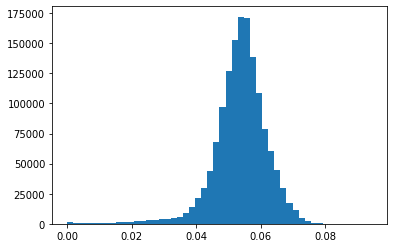

In [9]:
plots.hist.from_distances(COSINE_DIST_CORR_AVG, max=None, bins=50)

We get a roughly normal distribution out of this.  

The average to domain count distribution for average imputation looks like this:

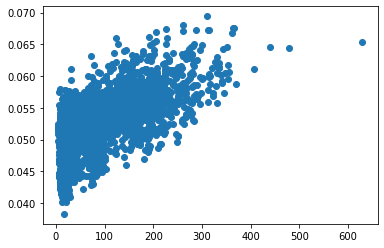

In [26]:
COSINE_DIST_CORR_AVG_MATRIX = pd.DataFrame(index=BGC_IDS, columns=BGC_IDS)
for pair in COSINE_DIST_CORR_AVG:
    bgc_name_a, bgc_name_b, distance = pair
    bgc_id_a = BGC_NAME_ID_DICT[bgc_name_a]
    bgc_id_b = BGC_NAME_ID_DICT[bgc_name_b]
    COSINE_DIST_CORR_AVG_MATRIX.at[bgc_id_a, bgc_id_b] = distance
COSINE_DIST_CORR_AVG_MEAN = pd.DataFrame(COSINE_DIST_CORR_AVG_MATRIX.mean(axis=1), columns=["sum_dist"])
plt.scatter(FEATURES_COUNTS, COSINE_DIST_CORR_AVG_MEAN)

This distribution makes a bit more sense. Here are the stats when we repeat the cutoffs:

In [29]:
predictions.tests.distance.run_upper(
    COSINE_DIST_CORR_AVG,
    TRUTH_PAIRS,
    upper_range=8,
    upper_cutoff_step=0.01,
    upper_cutoff_start=0.02
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.02,0,1338853,8794,NA,0.0,1.0,0.999,NA,0.999,0,0,1338853,1832
0.03,0,1324443,23204,NA,0.0,1.0,1.0,NA,1.0,0,0,1324443,624
0.04,0,1283395,64252,NA,0.0,1.0,1.0,NA,1.0,0,0,1283395,257
0.05,0,978035,369612,NA,0.0,1.0,1.0,NA,1.0,0,0,978035,117
0.06,0,234663,1112984,NA,0.0,1.0,1.0,NA,1.0,0,0,234663,45
0.07,0,14819,1332828,NA,0.0,1.0,1.0,NA,1.0,0,0,14819,4
0.08,0,81,1347566,NA,NA,1.0,1.0,NA,1.0,0,0,81,0
0.09,0,3,1347644,NA,NA,1.0,1.0,NA,1.0,0,0,3,0


This isn't as good, as is expected. The distribution looks good but these cutofss don't give results as good as the previous ones